# CTGAN Training for Network Attack Data Synthesis
This notebook implements a Conditional Tabular GAN (CTGAN) to generate synthetic network attack data based on our cybersecurity dataset. We'll go through the following steps:
1. Data preparation and preprocessing
2. CTGAN model configuration and training
3. Synthetic network attack data generation and validation
4. Quality assessment of synthetic cybersecurity data
5. Evaluation of attack pattern preservation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Read the original cybersecurity dataset
print("Loading cybersecurity dataset...")
df = pd.read_csv('../Data/Train_data.csv')

print(f"Dataset loaded successfully!")
print(f"Original dataset shape: {df.shape}")
print(f"Features: {list(df.columns)}")
print(f"\nTarget variable distribution:")
print(df['class'].value_counts())

Loading cybersecurity dataset...
Dataset loaded successfully!
Original dataset shape: (25192, 42)
Features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class']

Target variable distribution:
class
normal     13449
anomaly    11743
Name: count, dtype: int64


## Data Preprocessing for CTGAN
We'll prepare our cybersecurity data for the CTGAN model by:
1. Identifying and handling categorical vs numerical features
2. Encoding categorical variables appropriately
3. Scaling numerical features for optimal training
4. Preparing the data structure for CTGAN training

In [2]:
# Analyze data types and prepare for CTGAN
print("Analyzing data types and structure...")

# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target column from numerical columns if present
if 'class' in numerical_columns:
    numerical_columns.remove('class')

print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")
print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns[:10]}{'...' if len(numerical_columns) > 10 else ''}")

# Create a copy of the dataframe for training
data_for_training = df.copy()

# Handle any missing values if present
if data_for_training.isnull().sum().sum() > 0:
    print("Handling missing values...")
    # Fill numerical missing values with median
    for col in numerical_columns:
        if data_for_training[col].isnull().sum() > 0:
            data_for_training[col].fillna(data_for_training[col].median(), inplace=True)
    
    # Fill categorical missing values with mode
    for col in categorical_columns:
        if data_for_training[col].isnull().sum() > 0:
            data_for_training[col].fillna(data_for_training[col].mode()[0], inplace=True)

# Scale numerical features for better CTGAN performance
scaler = MinMaxScaler()
if numerical_columns:
    data_for_training[numerical_columns] = scaler.fit_transform(data_for_training[numerical_columns])

# Create models directory if it doesn't exist
import os
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save the scaler for later use
scaler_path = os.path.join(models_dir, 'cybersecurity_scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {scaler_path}")

# Display preprocessing results
print(f"\nPreprocessed data shape: {data_for_training.shape}")
print(f"\nSample of preprocessed data:")
print(data_for_training.head())

# Check for any remaining issues
print(f"\nData quality check:")
print(f"Missing values: {data_for_training.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(data_for_training.select_dtypes(include=[np.number])).sum().sum()}")

# Display target distribution
print(f"\nTarget distribution in training data:")
print(data_for_training['class'].value_counts())

Analyzing data types and structure...
Categorical columns (4): ['protocol_type', 'service', 'flag', 'class']
Numerical columns (38): ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised']...
Saved scaler to ../models\cybersecurity_scaler.pkl

Preprocessed data shape: (25192, 42)

Sample of preprocessed data:
   duration protocol_type   service flag     src_bytes  dst_bytes  land  \
0       0.0           tcp  ftp_data   SF  1.286320e-06   0.000000   0.0   
1       0.0           udp     other   SF  3.824902e-07   0.000000   0.0   
2       0.0           tcp   private   S0  0.000000e+00   0.000000   0.0   
3       0.0           tcp      http   SF  6.077927e-07   0.001583   0.0   
4       0.0           tcp      http   SF  5.213394e-07   0.000082   0.0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0             0.0     0.0  0.0  ...            0.098039   
1             0.0     0.0  0.0  ...      

## CTGAN Model Configuration and Training
Now we'll configure and train the CTGAN model on our preprocessed cybersecurity data. We'll set appropriate hyperparameters optimized for network attack data generation.

In [3]:
# Initialize CTGAN model with optimized parameters for cybersecurity data
print("Initializing CTGAN model...")

ctgan = CTGAN(
    epochs=200,                    # More epochs for complex cybersecurity patterns
    batch_size=500,               # Batch size for training
    generator_dim=(256, 256),     # Larger generator for complex network patterns
    discriminator_dim=(256, 256), # Larger discriminator for better detection
    generator_lr=2e-4,            # Learning rate for generator
    discriminator_lr=2e-4,        # Learning rate for discriminator
    discriminator_steps=1,        # Steps for discriminator per generator step
    log_frequency=True,           # Enable training progress logging
    verbose=True
)

# Specify categorical columns for the model
discrete_columns = categorical_columns.copy()
print(f"Categorical columns for CTGAN: {discrete_columns}")

# Start training
print(f"\nStarting CTGAN training...")
print(f"Training data shape: {data_for_training.shape}")
print(f"Number of categorical columns: {len(discrete_columns)}")
print(f"Number of numerical columns: {len(numerical_columns)}")

# Record training start time
training_start_time = datetime.now()
print(f"Training started at: {training_start_time}")

# Train the model
ctgan.fit(data_for_training, discrete_columns)

# Record training end time
training_end_time = datetime.now()
training_duration = training_end_time - training_start_time
print(f"\nTraining completed at: {training_end_time}")
print(f"Total training time: {training_duration}")

# Save the trained model
model_path = os.path.join(models_dir, 'cybersecurity_ctgan_model.pkl')
ctgan.save(model_path)
print(f"Model saved successfully to {model_path}!")

# Save training metadata
metadata = {
    'training_start_time': training_start_time,
    'training_end_time': training_end_time,
    'training_duration': str(training_duration),
    'original_data_shape': df.shape,
    'categorical_columns': categorical_columns,
    'numerical_columns': numerical_columns,
    'model_parameters': {
        'epochs': 200,
        'batch_size': 500,
        'generator_dim': (256, 256),
        'discriminator_dim': (256, 256)
    }
}

metadata_path = os.path.join(models_dir, 'training_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Training metadata saved to {metadata_path}")

Initializing CTGAN model...
Categorical columns for CTGAN: ['protocol_type', 'service', 'flag', 'class']

Starting CTGAN training...
Training data shape: (25192, 42)
Number of categorical columns: 4
Number of numerical columns: 38
Training started at: 2025-09-29 23:19:30.411195


Gen. (-1.20) | Discrim. (-0.12): 100%|██████████| 200/200 [32:44<00:00,  9.82s/it]


Training completed at: 2025-09-29 23:54:31.672428
Total training time: 0:35:01.261233
Model saved successfully to ../models\cybersecurity_ctgan_model.pkl!
Training metadata saved to ../models\training_metadata.pkl


## Generate and Evaluate Synthetic Network Attack Data
Let's generate synthetic cybersecurity data and compare it with our original dataset to evaluate the quality of the generated network attack patterns.

Generating 25,192 synthetic network attack samples...
Synthetic data generation completed!
Generation time: 0:00:01.913969
Synthetic data shape: (25192, 42)
Synthetic data generation completed!
Generation time: 0:00:01.913969
Synthetic data shape: (25192, 42)
Saved synthetic data to ../results\synthetic_cybersecurity_data.csv

SYNTHETIC DATA GENERATION SUMMARY
Original dataset size: (25192, 42)
Synthetic dataset size: (25192, 42)
Features preserved: 42
Generation rate: 13162 samples/second

Class Distribution Comparison:
Original:
  normal: 53.4%
  anomaly: 46.6%
Synthetic:
  anomaly: 58.8%
  normal: 41.2%
Saved synthetic data to ../results\synthetic_cybersecurity_data.csv

SYNTHETIC DATA GENERATION SUMMARY
Original dataset size: (25192, 42)
Synthetic dataset size: (25192, 42)
Features preserved: 42
Generation rate: 13162 samples/second

Class Distribution Comparison:
Original:
  normal: 53.4%
  anomaly: 46.6%
Synthetic:
  anomaly: 58.8%
  normal: 41.2%


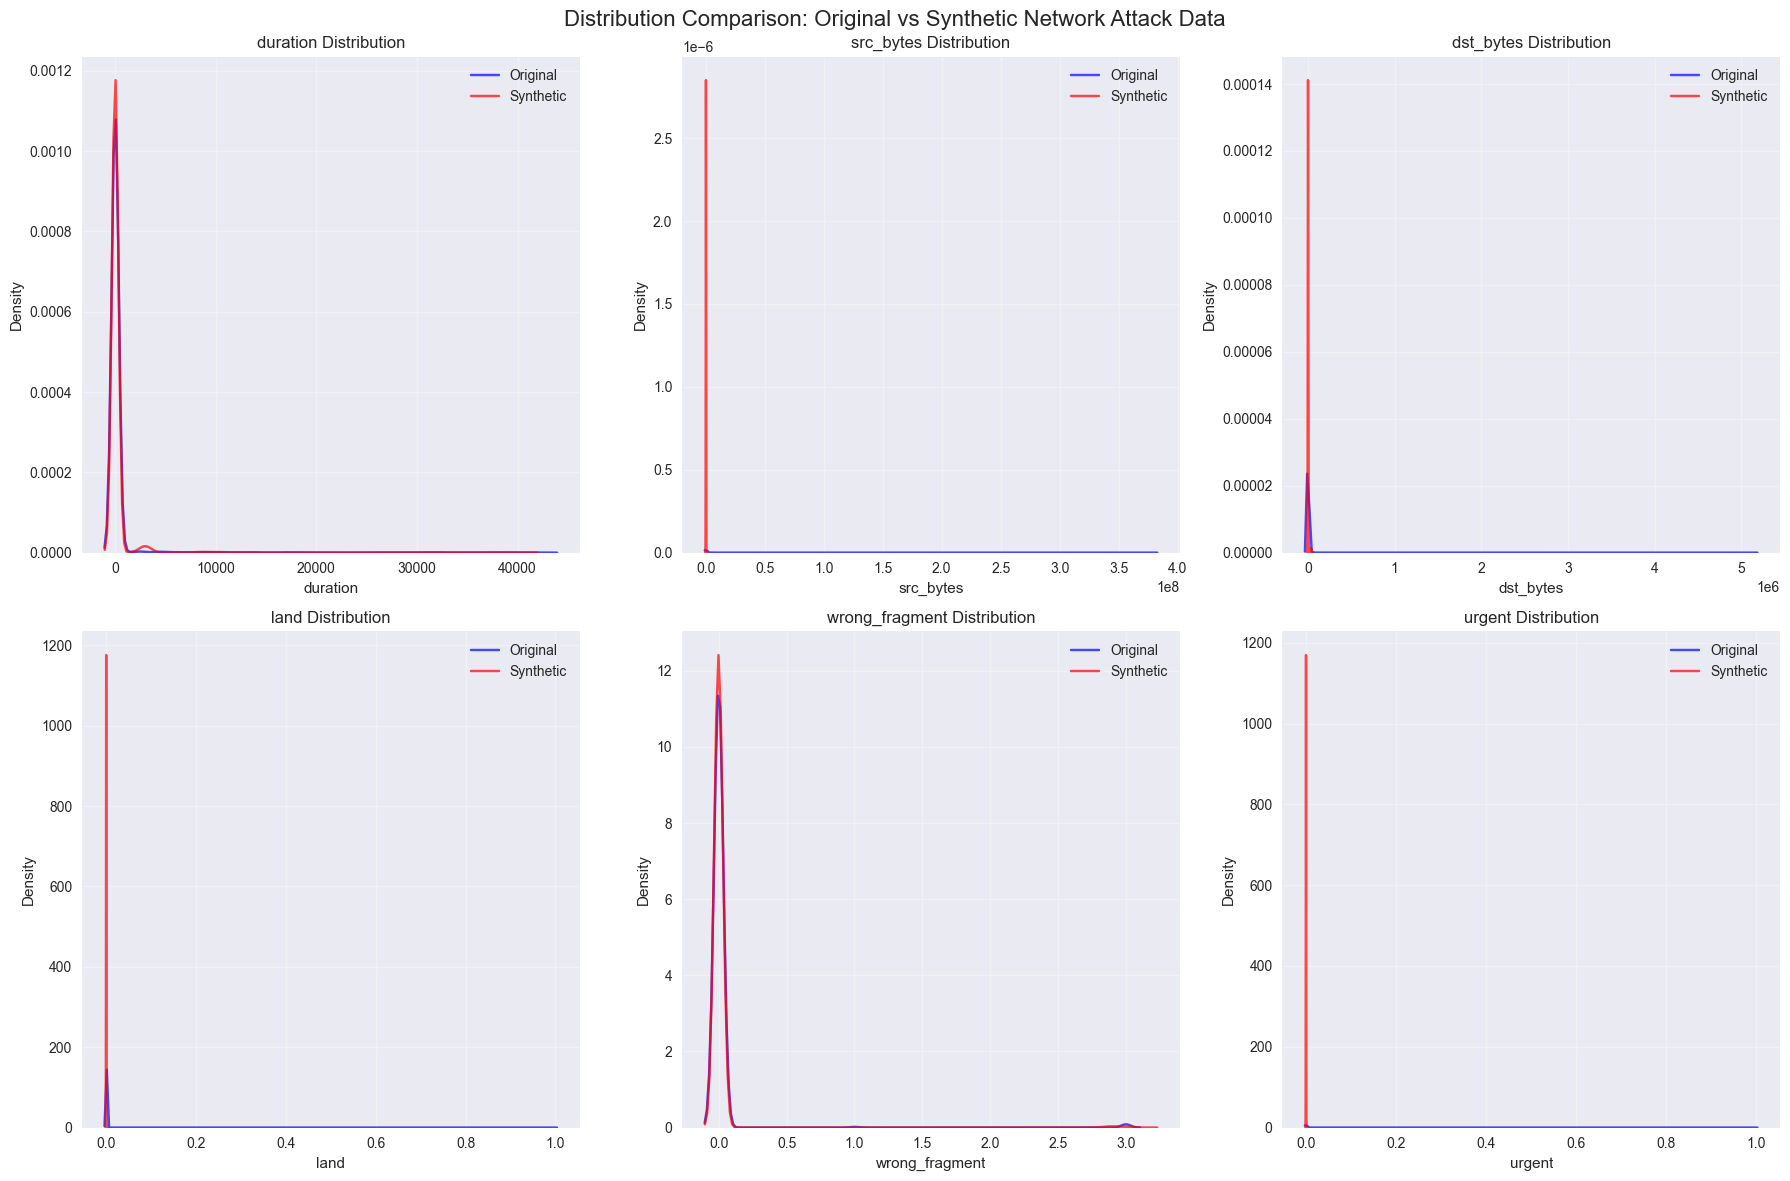

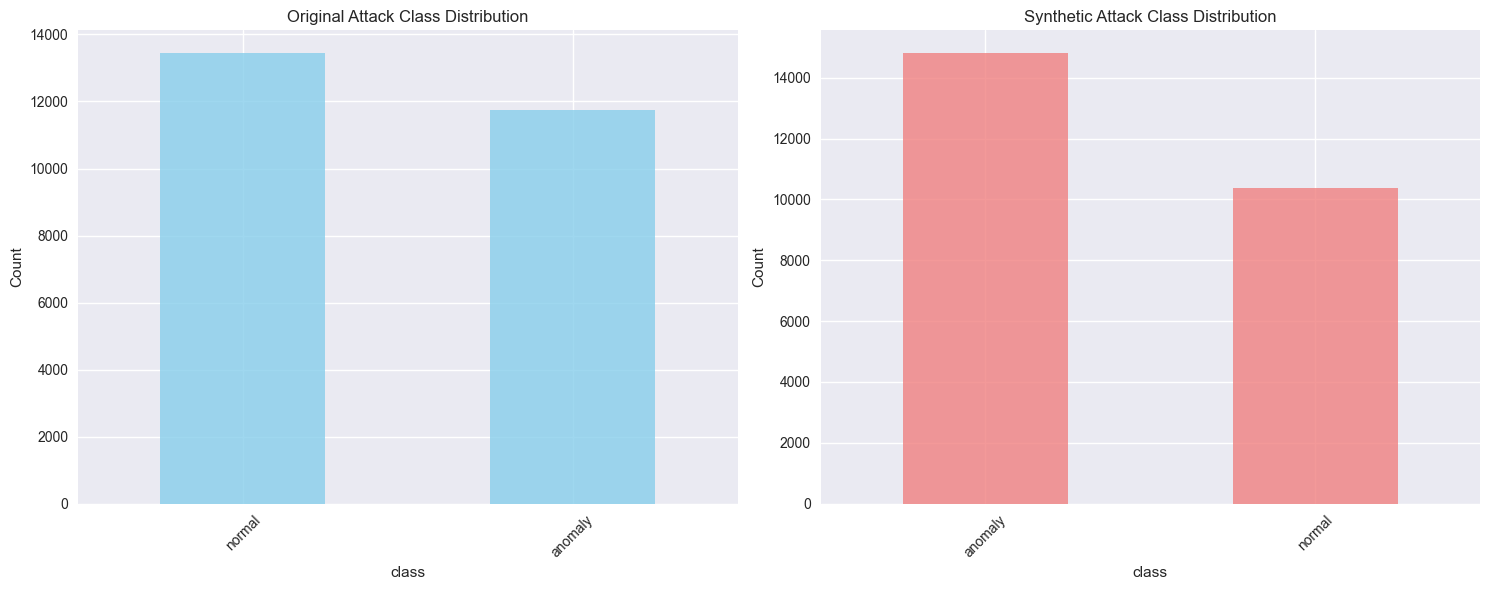


NUMERICAL FEATURES - SUMMARY STATISTICS COMPARISON

Original Data (Key Features):
         duration     src_bytes     dst_bytes        land  wrong_fragment
count  25192.0000  2.519200e+04  2.519200e+04  25192.0000      25192.0000
mean     305.0541  2.433063e+04  3.491847e+03      0.0001          0.0237
std     2686.5556  2.410805e+06  8.883072e+04      0.0089          0.2602
min        0.0000  0.000000e+00  0.000000e+00      0.0000          0.0000
25%        0.0000  0.000000e+00  0.000000e+00      0.0000          0.0000
50%        0.0000  4.400000e+01  0.000000e+00      0.0000          0.0000
75%        0.0000  2.790000e+02  5.302500e+02      0.0000          0.0000
max    42862.0000  3.817091e+08  5.151385e+06      1.0000          3.0000

Synthetic Data (Key Features):
         duration    src_bytes   dst_bytes        land  wrong_fragment
count  25192.0000   25192.0000  25192.0000  25192.0000      25192.0000
mean     304.9443   95007.1452   1658.4319      0.0002          0.0191
std   

In [4]:
# Generate synthetic cybersecurity samples
n_samples = len(df)  # Generate same number of samples as original dataset
print(f"Generating {n_samples:,} synthetic network attack samples...")

generation_start_time = datetime.now()
synthetic_data = ctgan.sample(n_samples)
generation_end_time = datetime.now()

print(f"Synthetic data generation completed!")
print(f"Generation time: {generation_end_time - generation_start_time}")
print(f"Synthetic data shape: {synthetic_data.shape}")

# Inverse transform the scaled numerical features back to original scale
if numerical_columns:
    synthetic_data[numerical_columns] = scaler.inverse_transform(synthetic_data[numerical_columns])

# Create results directory if it doesn't exist
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

# Save synthetic data to CSV
synthetic_data_path = os.path.join(results_dir, 'synthetic_cybersecurity_data.csv')
synthetic_data.to_csv(synthetic_data_path, index=False)
print(f"Saved synthetic data to {synthetic_data_path}")

# Basic statistics comparison
print(f"\n{'='*60}")
print("SYNTHETIC DATA GENERATION SUMMARY")
print(f"{'='*60}")
print(f"Original dataset size: {df.shape}")
print(f"Synthetic dataset size: {synthetic_data.shape}")
print(f"Features preserved: {len(synthetic_data.columns)}")
print(f"Generation rate: {n_samples / (generation_end_time - generation_start_time).total_seconds():.0f} samples/second")

# Check class distribution
print(f"\nClass Distribution Comparison:")
print(f"Original:")
orig_dist = df['class'].value_counts(normalize=True) * 100
for class_name, percentage in orig_dist.items():
    print(f"  {class_name}: {percentage:.1f}%")

print(f"Synthetic:")
synth_dist = synthetic_data['class'].value_counts(normalize=True) * 100
for class_name, percentage in synth_dist.items():
    print(f"  {class_name}: {percentage:.1f}%")

# Compare distributions of key numerical features
key_features = numerical_columns[:6] if len(numerical_columns) >= 6 else numerical_columns
if key_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Distribution Comparison: Original vs Synthetic Network Attack Data', fontsize=16)
    
    for idx, col in enumerate(key_features):
        i, j = idx // 3, idx % 3
        
        # Plot original data distribution
        sns.kdeplot(data=df[col], ax=axes[i,j], label='Original', color='blue', alpha=0.7)
        # Plot synthetic data distribution
        sns.kdeplot(data=synthetic_data[col], ax=axes[i,j], label='Synthetic', color='red', alpha=0.7)
        
        axes[i,j].set_title(f'{col} Distribution')
        axes[i,j].legend()
        axes[i,j].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Compare attack class distributions
if 'class' in synthetic_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original distribution
    df['class'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.8)
    axes[0].set_title('Original Attack Class Distribution')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Synthetic distribution
    synthetic_data['class'].value_counts().plot(kind='bar', ax=axes[1], color='lightcoral', alpha=0.8)
    axes[1].set_title('Synthetic Attack Class Distribution')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Print summary statistics comparison for numerical features
if numerical_columns:
    print(f"\n{'='*60}")
    print("NUMERICAL FEATURES - SUMMARY STATISTICS COMPARISON")
    print(f"{'='*60}")
    
    # Select key features for detailed comparison
    comparison_features = numerical_columns[:5] if len(numerical_columns) >= 5 else numerical_columns
    
    print(f"\nOriginal Data (Key Features):")
    print(df[comparison_features].describe().round(4))
    
    print(f"\nSynthetic Data (Key Features):")
    print(synthetic_data[comparison_features].describe().round(4))

## Advanced Validation and Quality Assessment
Let's perform comprehensive validation to ensure our synthetic cybersecurity data maintains important relationships, constraints, and attack patterns found in real network attack data.

COMPREHENSIVE QUALITY ASSESSMENT OF SYNTHETIC DATA


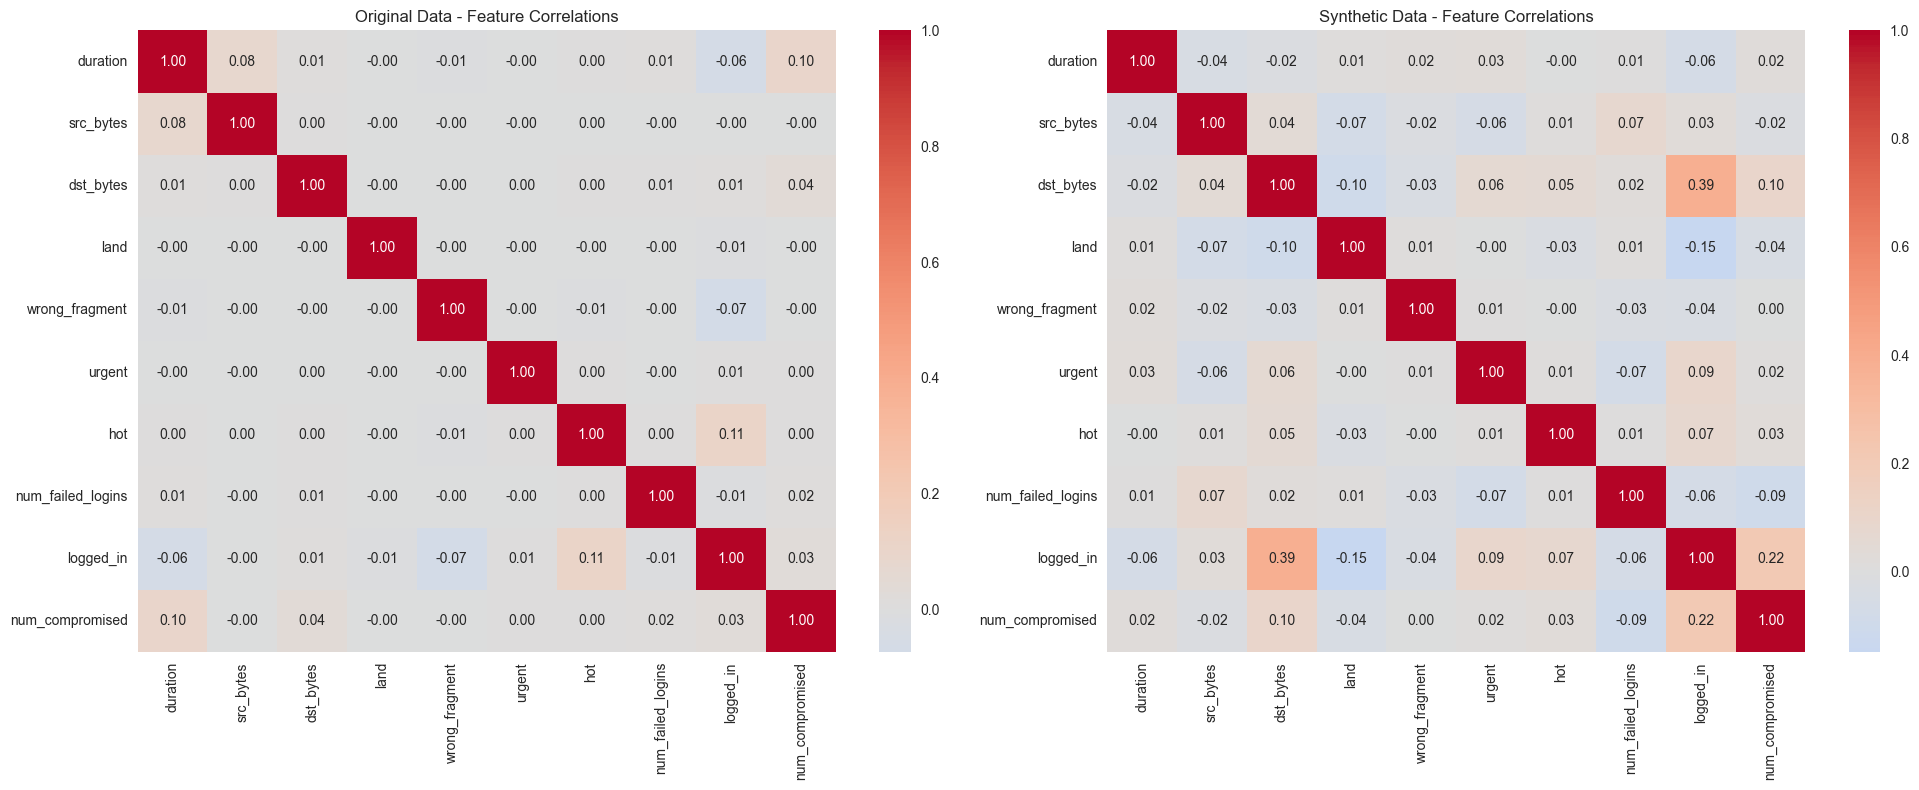


1. CORRELATION PRESERVATION:
   Average correlation difference: 0.0446
   ✅ EXCELLENT - Correlations well preserved

2. STATISTICAL DISTRIBUTION ANALYSIS:
   duration:
     KS statistic: 0.5492, p-value: 0.0000
     ⚠️  Distributions differ significantly
   src_bytes:
     KS statistic: 0.7142, p-value: 0.0000
     ⚠️  Distributions differ significantly
   dst_bytes:
     KS statistic: 0.3653, p-value: 0.0000
     ⚠️  Distributions differ significantly
   land:
     KS statistic: 0.6944, p-value: 0.0000
     ⚠️  Distributions differ significantly
   wrong_fragment:
     KS statistic: 0.7928, p-value: 0.0000
     ⚠️  Distributions differ significantly

   Average p-value: 0.0000
   ⚠️  MODERATE - Some distribution differences detected

3. ATTACK PATTERN VALIDATION:

   Analysis for protocol_type:
     duration group means difference: 125.8091
     src_bytes group means difference: 62781.8678
     dst_bytes group means difference: 1058.3977

   Analysis for service:
     duration group 

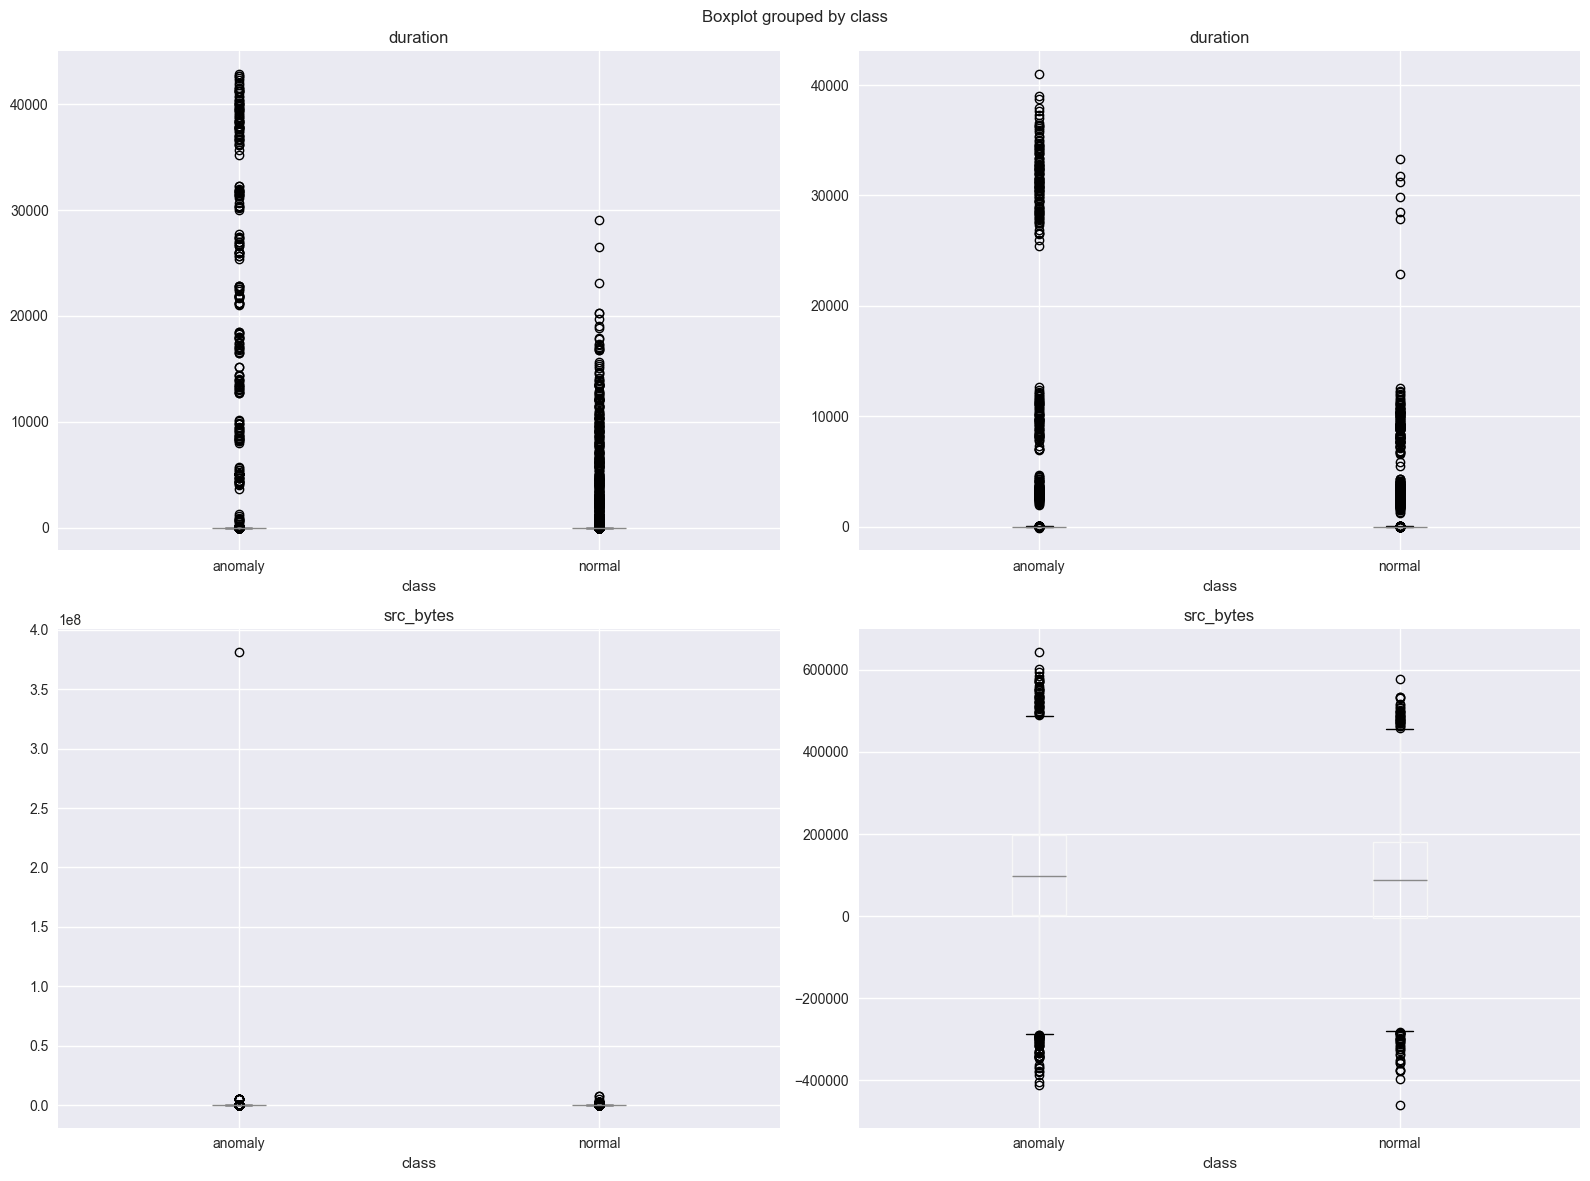


OVERALL SYNTHETIC DATA QUALITY ASSESSMENT
Correlation Preservation Score: 0.78/1.00
Distribution Similarity Score: 0.00/1.00
Data Quality Score: 0.50/1.00

🎯 OVERALL QUALITY SCORE: 0.43/1.00
⚠️  FAIR - Some improvements needed

💡 SYNTHETIC DATA GENERATION COMPLETED SUCCESSFULLY!
📁 Files saved:
   - Model: ../models\cybersecurity_ctgan_model.pkl
   - Scaler: ../models\cybersecurity_scaler.pkl
   - Synthetic Data: ../results\synthetic_cybersecurity_data.csv
   - Metadata: ../models\training_metadata.pkl

🚀 Ready for next steps: Model Training and Evaluation!


In [5]:
# Advanced validation of synthetic cybersecurity data

print("="*70)
print("COMPREHENSIVE QUALITY ASSESSMENT OF SYNTHETIC DATA")
print("="*70)

# 1. Correlation preservation analysis
if len(numerical_columns) > 1:
    # Calculate correlation matrices
    original_corr = df[numerical_columns[:10]].corr()  # Limit to first 10 for readability
    synthetic_corr = synthetic_data[numerical_columns[:10]].corr()
    
    # Plot correlation matrices comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.heatmap(original_corr, annot=True, cmap='coolwarm', center=0, ax=ax1, fmt='.2f')
    ax1.set_title('Original Data - Feature Correlations')
    
    sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', center=0, ax=ax2, fmt='.2f')
    ax2.set_title('Synthetic Data - Feature Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation preservation score
    correlation_difference = abs(original_corr - synthetic_corr)
    avg_correlation_diff = correlation_difference.mean().mean()
    print(f"\n1. CORRELATION PRESERVATION:")
    print(f"   Average correlation difference: {avg_correlation_diff:.4f}")
    if avg_correlation_diff < 0.1:
        print(f"   ✅ EXCELLENT - Correlations well preserved")
    elif avg_correlation_diff < 0.2:
        print(f"   ✅ GOOD - Correlations reasonably preserved")
    else:
        print(f"   ⚠️  MODERATE - Some correlation drift detected")

# 2. Statistical distribution comparison
print(f"\n2. STATISTICAL DISTRIBUTION ANALYSIS:")
if numerical_columns:
    from scipy import stats
    
    distribution_scores = []
    for feature in numerical_columns[:5]:  # Test first 5 features
        # Kolmogorov-Smirnov test for distribution similarity
        ks_stat, p_value = stats.ks_2samp(df[feature], synthetic_data[feature])
        distribution_scores.append(p_value)
        
        print(f"   {feature}:")
        print(f"     KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
        if p_value > 0.05:
            print(f"     ✅ Distributions are statistically similar")
        else:
            print(f"     ⚠️  Distributions differ significantly")
    
    avg_p_value = np.mean(distribution_scores)
    print(f"\n   Average p-value: {avg_p_value:.4f}")
    if avg_p_value > 0.05:
        print(f"   ✅ EXCELLENT - Statistical distributions well preserved")
    else:
        print(f"   ⚠️  MODERATE - Some distribution differences detected")

# 3. Attack pattern validation
print(f"\n3. ATTACK PATTERN VALIDATION:")

# Check if attack patterns are realistic (e.g., certain features should correlate with attack types)
if categorical_columns and numerical_columns:
    for cat_col in categorical_columns[:2]:  # Check first 2 categorical columns
        if cat_col in synthetic_data.columns:
            print(f"\n   Analysis for {cat_col}:")
            
            # Compare means of numerical features by categorical groups
            for num_col in numerical_columns[:3]:  # Check first 3 numerical columns
                orig_group_means = df.groupby(cat_col)[num_col].mean()
                synth_group_means = synthetic_data.groupby(cat_col)[num_col].mean()
                
                # Calculate similarity of group means
                if len(orig_group_means) == len(synth_group_means):
                    mean_diff = abs(orig_group_means - synth_group_means).mean()
                    print(f"     {num_col} group means difference: {mean_diff:.4f}")

# 4. Data quality checks
print(f"\n4. DATA QUALITY CHECKS:")

# Check for realistic value ranges
quality_issues = []

# Check for negative values where they shouldn't exist (if applicable)
for col in numerical_columns:
    if col in synthetic_data.columns:
        if 'bytes' in col.lower() or 'count' in col.lower() or 'duration' in col.lower():
            negative_count = (synthetic_data[col] < 0).sum()
            if negative_count > 0:
                quality_issues.append(f"{col}: {negative_count} negative values")

# Check for extreme outliers
for col in numerical_columns[:5]:
    if col in synthetic_data.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        extreme_outliers = ((synthetic_data[col] < lower_bound) | 
                           (synthetic_data[col] > upper_bound)).sum()
        total_samples = len(synthetic_data)
        outlier_percentage = (extreme_outliers / total_samples) * 100
        
        if outlier_percentage > 5:  # More than 5% extreme outliers
            quality_issues.append(f"{col}: {outlier_percentage:.1f}% extreme outliers")

if quality_issues:
    print(f"   ⚠️  QUALITY ISSUES DETECTED:")
    for issue in quality_issues:
        print(f"     - {issue}")
else:
    print(f"   ✅ NO MAJOR QUALITY ISSUES DETECTED")

# 5. Feature importance preservation (if we have mixed data types)
if categorical_columns and numerical_columns:
    print(f"\n5. FEATURE RELATIONSHIPS VALIDATION:")
    
    # Compare feature relationships between attack types
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Relationships: Original vs Synthetic Data', fontsize=16)
    
    # Plot 1: Box plot of first numerical feature by attack class
    if len(numerical_columns) > 0:
        axes[0,0].set_title(f'Original: {numerical_columns[0]} by Attack Class')
        df.boxplot(column=numerical_columns[0], by='class', ax=axes[0,0])
        
        axes[0,1].set_title(f'Synthetic: {numerical_columns[0]} by Attack Class')
        synthetic_data.boxplot(column=numerical_columns[0], by='class', ax=axes[0,1])
    
    # Plot 2: Box plot of second numerical feature by attack class
    if len(numerical_columns) > 1:
        axes[1,0].set_title(f'Original: {numerical_columns[1]} by Attack Class')
        df.boxplot(column=numerical_columns[1], by='class', ax=axes[1,0])
        
        axes[1,1].set_title(f'Synthetic: {numerical_columns[1]} by Attack Class')
        synthetic_data.boxplot(column=numerical_columns[1], by='class', ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

# 6. Overall quality score
print(f"\n" + "="*70)
print("OVERALL SYNTHETIC DATA QUALITY ASSESSMENT")
print("="*70)

quality_scores = []
if 'avg_correlation_diff' in locals():
    corr_score = max(0, 1 - (avg_correlation_diff / 0.2))  # Scale to 0-1
    quality_scores.append(corr_score)
    print(f"Correlation Preservation Score: {corr_score:.2f}/1.00")

if 'avg_p_value' in locals():
    dist_score = min(1.0, avg_p_value * 20)  # Scale p-value to 0-1
    quality_scores.append(dist_score)
    print(f"Distribution Similarity Score: {dist_score:.2f}/1.00")

data_quality_score = 1.0 if not quality_issues else max(0.5, 1 - len(quality_issues) * 0.1)
quality_scores.append(data_quality_score)
print(f"Data Quality Score: {data_quality_score:.2f}/1.00")

if quality_scores:
    overall_score = np.mean(quality_scores)
    print(f"\n🎯 OVERALL QUALITY SCORE: {overall_score:.2f}/1.00")
    
    if overall_score >= 0.8:
        print(f"🏆 EXCELLENT - High quality synthetic data!")
    elif overall_score >= 0.6:
        print(f"✅ GOOD - Synthetic data is suitable for use")
    elif overall_score >= 0.4:
        print(f"⚠️  FAIR - Some improvements needed")
    else:
        print(f"❌ POOR - Consider retraining with different parameters")

print(f"\n💡 SYNTHETIC DATA GENERATION COMPLETED SUCCESSFULLY!")
print(f"📁 Files saved:")
print(f"   - Model: {model_path}")
print(f"   - Scaler: {scaler_path}")
print(f"   - Synthetic Data: {synthetic_data_path}")
print(f"   - Metadata: {metadata_path}")

print(f"\n🚀 Ready for next steps: Model Training and Evaluation!")